In [8]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from api import *
from queries import *
from getpass import getpass

print(tf.__version__)

api = DB(params={'user': 'macslab',
                  'password': getpass(),
                  'database': 'uav2_db',
                  'host': 'localhost',
                  'port': '5432'})

2.8.0


 ··········


[INFO] connecting to db.
[INFO] connected.


In [186]:
flights = api.execute(queries.GET_FLIGHT_COUNTS())
print('total flights: ', flights['flights'].sum())
flights.head()

total flights:  8899


,uav_id,flights,failures
0,32,93,8.0
1,52,89,8.0
2,72,75,8.0
3,92,83,8.0
4,112,77,8.0


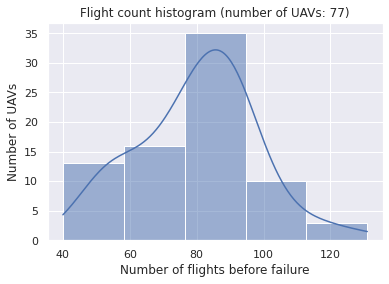

In [187]:
ax = sns.histplot(data=flights[flights['failures'] == 8], x="flights", kde=True, bins=5)
ax.set(xlabel='Number of flights before failure',
       ylabel='Number of UAVs',
       title='Flight count histogram (number of UAVs: {})'.format(len(flights[flights['failures'] == 8])))
plt.show()

In [52]:
stops = api.execute(queries.GET_STOP_COUNTS)
stops.head()

,description,stop_code,count
0,arrival success,4,6999
1,low voltage,2,564
2,position error,3,62
3,position error variance,5,38
4,low soc,1,5


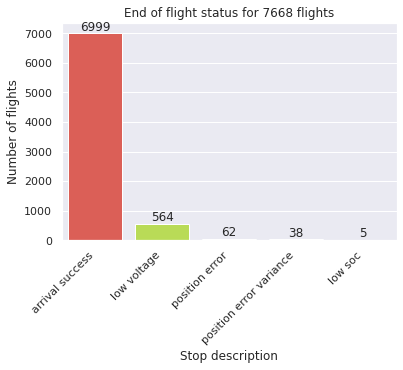

In [188]:
ax = sns.barplot(x='description', y='count', data=stops,
            palette = 'hls', 
            capsize = 0.05,             
            saturation = 8,             
            errcolor = 'gray', errwidth = 2,  
            ci = 'sd'   
            )
ax.bar_label(ax.containers[0])
ax.set(xlabel='Stop description',
       ylabel='Number of flights',
       title='End of flight status for {} flights'.format(stops['count'].sum()))
plt.xticks(rotation=45, ha='right')
plt.show()

In [138]:
telemetry = api.execute(queries.GET_TELEMETRY_DATA(stop_code=4, limit=2000))
flight_ids = (pd.unique(telemetry['flight_id']))
print(flight_ids)
telemetry = telemetry[telemetry['flight_id'] == flight_ids[0]]
print(len(telemetry))
telemetry.head()

[1 2]
960


,uav_id,trajectory_id,stop_code,dt,battery_true_v,battery_true_z,battery_true_r,battery_true_i,battery_hat_v,battery_hat_z,...,z_pos_true,x_vel_gps,y_vel_gps,z_vel_gps,x_vel_true,y_vel_true,z_vel_true,velocity,acceleration,flight_id
0,32,43,4,2023-02-01 14:23:48,22.131804,0.993800,0.001048,0.702062,22.200000,0.993800,...,0.050000,0.017243,0.006375,-0.026154,0.000000,0.000000,0.000000,0.000000,0.588369,1
1,32,43,4,2023-02-01 14:23:49,22.065081,0.993214,0.001050,34.104949,22.147999,0.980362,...,0.402945,-0.087457,0.289147,0.568745,-0.086877,0.285498,0.600046,0.298424,0.238915,1
2,32,43,4,2023-02-01 14:23:50,22.043682,0.992622,0.000985,9.719071,21.948593,0.974646,...,1.078897,-0.190866,0.460395,0.797941,-0.202773,0.439458,0.801900,0.483984,0.420291,1
3,32,43,4,2023-02-01 14:23:51,22.098587,0.992045,0.001083,62.329454,21.961079,0.971567,...,1.821894,-0.218223,0.944372,0.779719,-0.203638,0.937836,0.790017,0.959689,0.536973,1
4,32,43,4,2023-02-01 14:23:52,22.058701,0.991444,0.001009,11.023412,21.907066,0.971669,...,2.572005,-0.018387,1.377031,0.766550,-0.004495,1.386269,0.748878,1.386276,0.787477,1


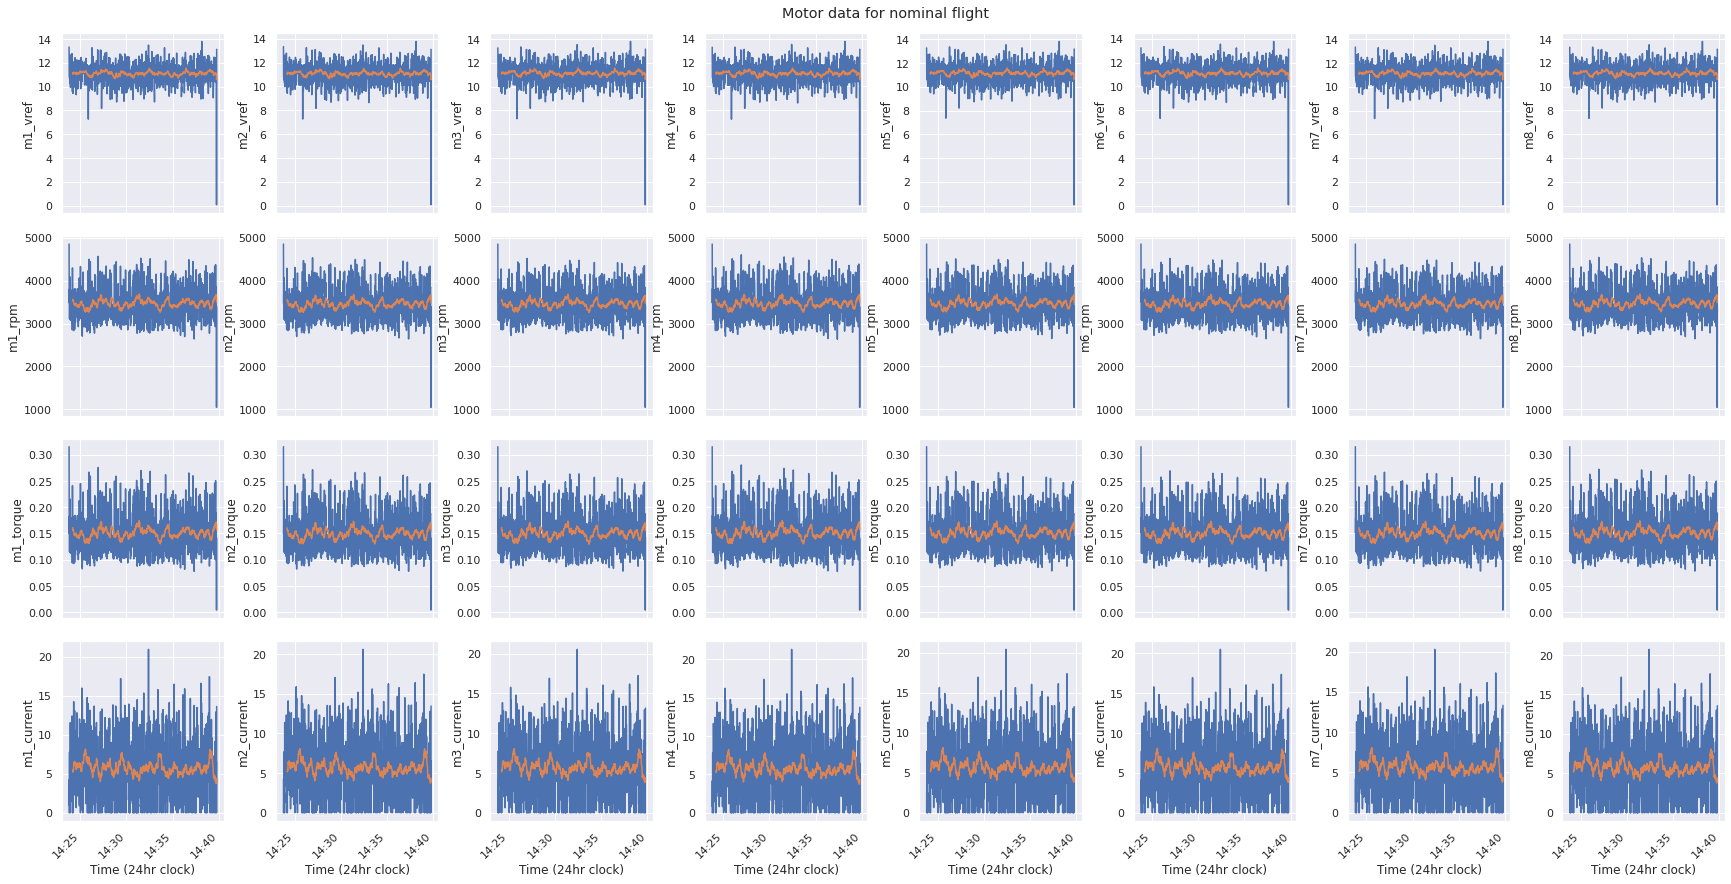

In [139]:
fig, axes = plt.subplots(4, 8, sharex=True, figsize=(24,12))
fig.suptitle('Motor data for nominal flight')
fig.tight_layout()

cols = ['vref', 'rpm', 'torque', 'current']

for i in range(len(cols)):
    for j in range(8):
        sns.lineplot(ax=axes[i,j], data=telemetry, x='dt', y=f'm{j+1}_{cols[i]}')
        telemetry['tmp_avg'] = telemetry[f'm{j+1}_{cols[i]}'].rolling(25).mean()
        sns.lineplot(ax=axes[i,j], data=telemetry, x='dt', y='tmp_avg')
        axes[i,j].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
        plt.setp(axes[i,j].xaxis.get_majorticklabels(), rotation=45, ha='right')
        axes[i,j].set(xlabel='Time (24hr clock)')
        #axes[i,j].set_title(f'm{j}_{cols[i]}')
fig.savefig('motor_plots.png')

In [124]:
[x for x in telemetry.columns if 'battery' in x]

['battery_true_v',
 'battery_true_z',
 'battery_true_r',
 'battery_true_i',
 'battery_hat_v',
 'battery_hat_z',
 'battery_hat_r',
 'battery_hat_z_var',
 'battery_hat_r_var']

In [ ]:
cols = [x for x in telemetry.columns if 'battery' in x]

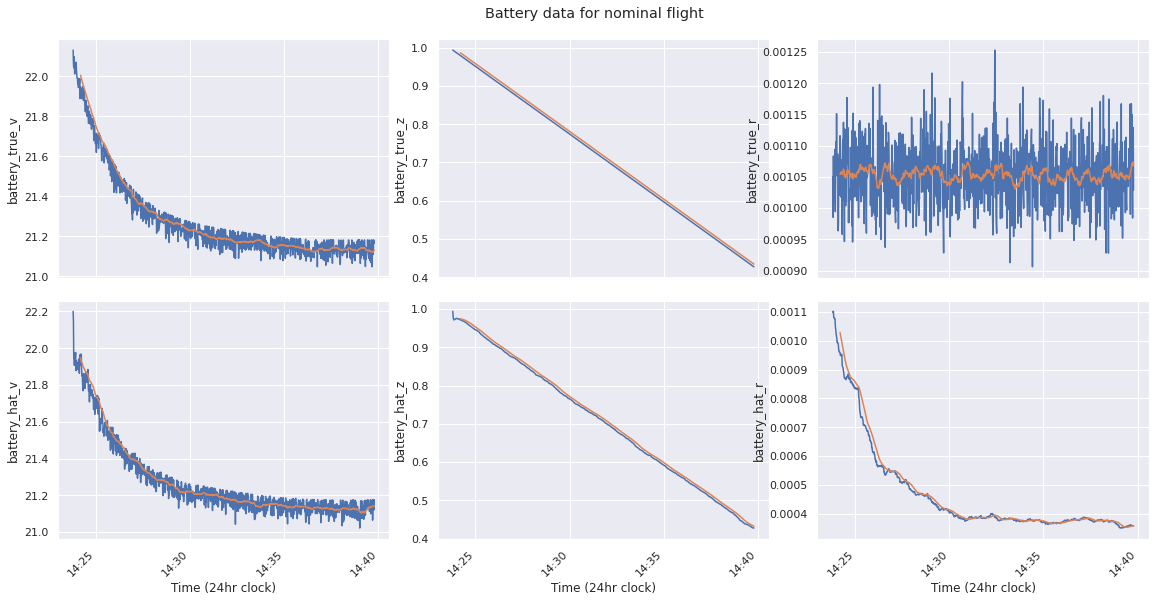

In [140]:
fig, axes = plt.subplots(2,3, sharex=True, figsize=(16,8))
fig.suptitle('Battery data for nominal flight')
fig.tight_layout()

cols = ['v', 'z', 'r']
batt = ['true', 'hat']

for i in range(len(batt)):
    for j in range(len(cols)):
        y = f'battery_{batt[i]}_{cols[j]}'
        sns.lineplot(ax=axes[i,j], data=telemetry, x='dt', y=y)
        telemetry['tmp_avg'] = telemetry[y].rolling(25).mean()
        sns.lineplot(ax=axes[i,j], data=telemetry, x='dt', y='tmp_avg')
        axes[i,j].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
        plt.setp(axes[i,j].xaxis.get_majorticklabels(), rotation=45, ha='right')
        axes[i,j].set(xlabel='Time (24hr clock)')
        #axes[i,j].set_title(f'm{j}_{cols[i]}')
#fig.savefig('battery_plots.png')

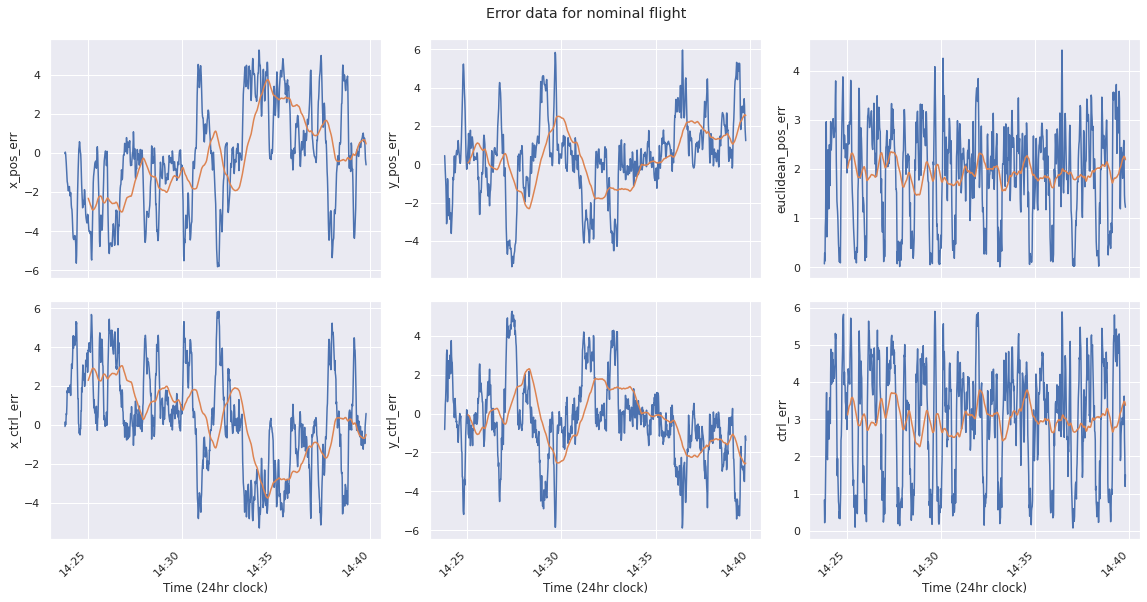

In [163]:
fig, axes = plt.subplots(2,3, sharex=True, figsize=(16,8))
fig.suptitle('Error data for nominal flight')
fig.tight_layout()

telemetry['ctrl_err'] = np.sqrt(telemetry['x_ctrl_err']**2 + telemetry['y_ctrl_err']**2)

cols = ['x_pos_err',
 'y_pos_err',
 'euclidean_pos_err',
 'x_ctrl_err',
 'y_ctrl_err',
 'ctrl_err']

for i in range(2):
    for j in range(3):
        y = cols[i*3+j]
        #print(y)
        sns.lineplot(ax=axes[i,j], data=telemetry, x='dt', y=y)
        telemetry['tmp_avg'] = telemetry[y].rolling(75).mean()
        sns.lineplot(ax=axes[i,j], data=telemetry, x='dt', y='tmp_avg')
        axes[i,j].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
        plt.setp(axes[i,j].xaxis.get_majorticklabels(), rotation=45, ha='right')
        axes[i,j].set(xlabel='Time (24hr clock)')

In [182]:
from math import pi, sqrt, exp

def gauss(n=11,sigma=1):
    r = range(-int(n/2),int(n/2)+1)
    return [1 / (sigma * sqrt(2*pi)) * exp(-float(x)**2/(2*sigma**2)) for x in r]

import numpy as np
from scipy import signal
sig = np.repeat([0., 1., 0.], 100)
win = signal.windows.gaussian(60, 12)
filtered = signal.convolve(sig, win, mode='same') / sum(win)

In [178]:
y

'velocity'

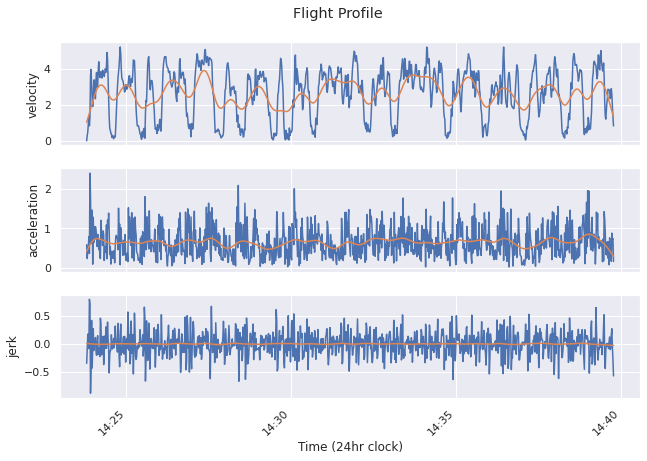

In [183]:
fig, axes = plt.subplots(3,1, sharex=True, figsize=(9,6))
fig.suptitle('Flight Profile')
fig.tight_layout()

telemetry['jerk'] = np.gradient(telemetry['acceleration'])
#telemetry['jerk'] = signal.convolve(telemetry['acceleration'], win, mode='same') / sum(win)

cols = ['velocity', 'acceleration', 'jerk']

j = 0
for i in range(3):
    y = cols[i]
    sns.lineplot(ax=axes[i], data=telemetry, x='dt', y=y)
    telemetry['tmp_avg'] = telemetry[y].rolling(75).mean()
    telemetry['tmp_avg'] = signal.convolve(telemetry[y], win, mode='same') / sum(win)
    sns.lineplot(ax=axes[i], data=telemetry, x='dt', y='tmp_avg')
    axes[i].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45, ha='right')
    axes[i].set(xlabel='Time (24hr clock)')

In [114]:
import queries
import matplotlib.dates as md

In [90]:
telemetry.columns.tolist()

['uav_id',
 'trajectory_id',
 'stop_code',
 'dt',
 'battery_true_v',
 'battery_true_z',
 'battery_true_r',
 'battery_true_i',
 'battery_hat_v',
 'battery_hat_z',
 'battery_hat_r',
 'battery_hat_z_var',
 'battery_hat_r_var',
 'wind_gust_x',
 'wind_gust_y',
 'wind_gust_z',
 'wind_const_x',
 'wind_const_y',
 'wind_const_z',
 'wind_direction',
 'wind_magnitude',
 'm1_vref',
 'm1_rpm',
 'm1_torque',
 'm1_current',
 'm2_vref',
 'm2_rpm',
 'm2_torque',
 'm2_current',
 'm3_vref',
 'm3_rpm',
 'm3_torque',
 'm3_current',
 'm4_vref',
 'm4_rpm',
 'm4_torque',
 'm4_current',
 'm5_vref',
 'm5_rpm',
 'm5_torque',
 'm5_current',
 'm6_vref',
 'm6_rpm',
 'm6_torque',
 'm6_current',
 'm7_vref',
 'm7_rpm',
 'm7_torque',
 'm7_current',
 'm8_vref',
 'm8_rpm',
 'm8_torque',
 'm8_current',
 'x_pos_err',
 'y_pos_err',
 'euclidean_pos_err',
 'var_pos_err',
 'x_ctrl_err',
 'y_ctrl_err',
 'x_pos_gps',
 'y_pos_gps',
 'z_pos_gps',
 'x_pos_true',
 'y_pos_true',
 'z_pos_true',
 'x_vel_gps',
 'y_vel_gps',
 'z_vel_gps'

In [70]:
import queries

In [77]:
queries.__dict__

{'__name__': 'queries',
 '__loader__': <_frozen_importlib_external.SourceFileLoader at 0x7f1b335b96d0>,
 '__spec__': ModuleSpec(name='queries', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7f1b335b96d0>, origin='/home/macslab/uavtestbed/analysis/queries.py'),
 '__package__': '',
 '__file__': '/home/macslab/uavtestbed/analysis/queries.py',
 '__cached__': '/home/macslab/uavtestbed/analysis/__pycache__/queries.cpython-38.pyc',
 '__builtins__': {'__name__': 'builtins',
  '__doc__': "Built-in functions, exceptions, and other objects.\n\nNoteworthy: None is the `nil' object; Ellipsis represents `...' in slices.",
  '__package__': '',
  '__loader__': _frozen_importlib.BuiltinImporter,
  '__spec__': ModuleSpec(name='builtins', loader=<class '_frozen_importlib.BuiltinImporter'>),
  '__build_class__': <function __build_class__>,
  '__import__': <function __import__>,
  'abs': <function abs(x, /)>,
  'all': <function all(iterable, /)>,
  'any': <function any(iterable, /)>,
  'a

In [173]:
api.get_tables()

,table_name
0,dc_motor_tb
1,degradation_tb
2,esc_tb
3,gps_sensor_tb
4,octorotor_airframe_tb
...,...
20,telemetry_tb
21,true_age_tb
22,airframe_tb
23,uav_tb


In [12]:
pd.set_option('display.max_rows', 20)

## read the session table

In [14]:
sdf = pd.read_csv('session_tb.csv')
sdf.head()

,id,stop_code,z_start,z_end,v_start,v_end,m1_avg_current,m2_avg_current,m3_avg_current,m4_avg_current,...,flight_time,avg_current,amp_hours,dt_start,dt_stop,trajectory_id,uav_id,uav_version,flight_num,group_id
0,1,4,0.993800,0.426576,22.131804,21.069702,5.652881,5.617049,5.624873,5.660082,...,15.998202,45.804115,12.213058,2023-02-01 14:23:48.000 -0600,2023-02-01 14:39:47.892 -0600,43,32,1,1,2
1,2,4,1.001264,0.377616,22.200001,21.088465,5.544756,5.480921,5.502234,5.546040,...,18.506700,44.852024,13.834383,2023-02-01 14:24:08.000 -0600,2023-02-01 14:42:38.402 -0600,50,52,1,1,2
2,3,3,0.990282,0.881595,22.095013,21.353199,5.660747,5.620882,5.625356,5.648013,...,3.158333,45.790766,2.410375,2023-02-01 14:26:49.000 -0600,2023-02-01 14:29:58.500 -0600,41,212,1,1,2
3,4,4,0.991514,0.276512,22.107746,20.911417,5.619877,5.561819,5.573843,5.620331,...,20.184315,45.448240,15.289027,2023-02-01 14:24:48.000 -0600,2023-02-01 14:44:59.058 -0600,50,92,1,1,2
4,5,4,0.999583,0.195537,22.195286,20.409710,5.612782,5.567570,5.555225,5.598734,...,22.969171,45.373682,17.369931,2023-02-01 14:24:28.000 -0600,2023-02-01 14:47:26.150 -0600,37,72,1,1,2


## get successful flights of healthy portion of the flight data
- i.e. flight number < 15, stop_code == success (4)

In [25]:
healthy_df = sdf.loc[(sdf.flight_num < 15) & (sdf.stop_code == 4), :].sort_values(by=['uav_id', 'flight_num'])
healthy_df.head()

,id,stop_code,z_start,z_end,v_start,v_end,m1_avg_current,m2_avg_current,m3_avg_current,m4_avg_current,...,flight_time,avg_current,amp_hours,dt_start,dt_stop,trajectory_id,uav_id,uav_version,flight_num,group_id
0,1,4,0.993800,0.426576,22.131804,21.069702,5.652881,5.617049,5.624873,5.660082,...,15.998202,45.804115,12.213058,2023-02-01 14:23:48.000 -0600,2023-02-01 14:39:47.892 -0600,43,32,1,1,2
9,10,4,1.009406,0.442752,22.200001,21.085295,5.671905,5.584609,5.602109,5.651609,...,15.997449,45.745520,12.196860,2023-02-01 16:39:47.892 -0600,2023-02-01 16:55:47.739 -0600,43,32,1,2,2
21,22,4,1.000722,0.447839,22.200001,21.105835,5.684618,5.676188,5.681271,5.731025,...,15.992439,46.250379,12.327606,2023-02-01 18:55:47.739 -0600,2023-02-01 19:11:47.285 -0600,43,32,1,3,2
196,40,4,0.994239,0.445728,22.136492,21.117071,5.590321,5.539450,5.541286,5.604916,...,15.988407,45.271702,12.063707,2023-02-01 21:11:47.285 -0600,2023-02-01 21:27:46.589 -0600,43,32,1,4,2
479,61,4,0.995710,0.462237,22.152355,21.090883,5.510163,5.459881,5.470937,5.530604,...,15.998993,44.653452,11.906838,2023-02-01 23:27:46.589 -0600,2023-02-01 23:43:46.529 -0600,43,32,1,5,2


In [27]:
healthy_df.trajectory_id.value_counts()

41    40
47    39
50    38
39    37
33    36
      ..
28    10
38     9
30     8
26     8
40     7
Name: trajectory_id, Length: 28, dtype: int64

In [39]:
healthy_ids = healthy_df.id.values.tolist()
healthy_ids.sort()
healthy_ids[0:10]

[1, 2, 4, 5, 6, 7, 8, 9, 10, 11]

## repeat with degradation data

In [33]:
degdf = pd.read_csv('degradation_tb.csv').dropna(axis=1)
degdf.head()

,id,flight_id,q_deg,r_deg,m1_deg,m2_deg,m3_deg,m4_deg,m5_deg,m6_deg,m7_deg,m8_deg
0,1,1,21.729691,0.00105,0.266864,0.280000,0.28,0.271109,0.28,0.28,0.277189,0.274949
1,2,2,21.731365,0.00105,0.278716,0.271456,0.28,0.268015,0.28,0.28,0.280000,0.277690
2,3,3,21.648542,0.00105,0.267967,0.278530,0.28,0.269200,0.28,0.28,0.279808,0.276380
3,4,4,20.954548,0.00105,0.269890,0.280000,0.28,0.276005,0.28,0.28,0.280000,0.280000
4,5,5,21.732826,0.00105,0.267772,0.278882,0.28,0.267989,0.28,0.28,0.280000,0.269617


In [37]:
healthydeg = degdf[degdf['id'].isin(healthy_ids)]
healthydeg.head()

,id,flight_id,q_deg,r_deg,m1_deg,m2_deg,m3_deg,m4_deg,m5_deg,m6_deg,m7_deg,m8_deg
0,1,1,21.729691,0.00105,0.266864,0.280000,0.28,0.271109,0.28,0.28,0.277189,0.274949
1,2,2,21.731365,0.00105,0.278716,0.271456,0.28,0.268015,0.28,0.28,0.280000,0.277690
3,4,4,20.954548,0.00105,0.269890,0.280000,0.28,0.276005,0.28,0.28,0.280000,0.280000
4,5,5,21.732826,0.00105,0.267772,0.278882,0.28,0.267989,0.28,0.28,0.280000,0.269617
5,6,6,22.225050,0.00105,0.271002,0.276399,0.28,0.269457,0.28,0.28,0.280000,0.274469


## repeat with true age table

In [40]:
agedf = pd.read_csv('true_age_tb.csv')
healthyage = agedf[agedf['id'].isin(healthy_ids)]
healthyage.head()

,id,flight_id,stop_code,trajectory_id,uav_age,battery_age,m1_age,m2_age,m3_age,m4_age,m5_age,m6_age,m7_age,m8_age
0,1,1,4,43,16.005852,23.429209,1.507265,1.497711,1.499798,1.509186,1.506756,1.499056,1.500923,1.508844
1,2,2,4,50,18.545456,26.363382,1.710252,1.690563,1.697137,1.710648,1.704067,1.696812,1.699649,1.713026
3,4,4,4,50,20.298401,29.346478,1.890556,1.871025,1.875070,1.890709,1.886658,1.874792,1.876425,1.892321
4,5,5,4,37,23.101326,33.145580,2.148682,2.131375,2.126649,2.143305,2.145798,2.137393,2.132095,2.141247
5,6,6,4,31,18.245150,25.981594,1.685941,1.664313,1.665347,1.683882,1.680174,1.674055,1.673298,1.682462


[1, 10, 22, 40, 61, 81, 98, 118, 137, 158]

## read telemetry data

In [61]:
tmdf = pd.read_csv('telemetry_tb.csv')
tmdf.head()

,dt,battery_true_v,battery_true_z,battery_true_r,battery_true_i,battery_hat_v,battery_hat_z,battery_hat_r,battery_hat_z_var,battery_hat_r_var,...,z_pos_true,x_vel_gps,y_vel_gps,z_vel_gps,x_vel_true,y_vel_true,z_vel_true,velocity,acceleration,flight_id
0,2023-02-01 14:23:48.000,22.131804,0.993800,0.001048,0.702062,22.200000,0.993800,0.001100,0.000000,0.003000,...,0.050000,0.017243,0.006375,-0.026154,0.000000,0.000000,0.000000,0.000000,0.588369,1
1,2023-02-01 14:23:49.000,22.065081,0.993214,0.001050,34.104949,22.147999,0.980362,0.001100,1.332628,0.003000,...,0.402945,-0.087457,0.289147,0.568745,-0.086877,0.285498,0.600046,0.298424,0.238915,1
2,2023-02-01 14:23:50.000,22.043682,0.992622,0.000985,9.719071,21.948593,0.974646,0.001102,1.122036,0.002998,...,1.078897,-0.190866,0.460395,0.797941,-0.202773,0.439458,0.801900,0.483984,0.420291,1
3,2023-02-01 14:23:51.000,22.098587,0.992045,0.001083,62.329454,21.961079,0.971567,0.001102,0.984746,0.002998,...,1.821894,-0.218223,0.944372,0.779719,-0.203638,0.937836,0.790017,0.959689,0.536973,1
4,2023-02-01 14:23:52.000,22.058701,0.991444,0.001009,11.023412,21.907066,0.971669,0.001082,0.908168,0.002991,...,2.572005,-0.018387,1.377031,0.766550,-0.004495,1.386269,0.748878,1.386276,0.787477,1


In [3]:
tmdf = 

In [3]:
tmdf.columns

Index(['dt', 'battery_true_v', 'battery_true_z', 'battery_true_r',
       'battery_true_i', 'battery_hat_v', 'battery_hat_z', 'battery_hat_r',
       'battery_hat_z_var', 'battery_hat_r_var', 'wind_gust_x', 'wind_gust_y',
       'wind_gust_z', 'wind_const_x', 'wind_const_y', 'wind_const_z',
       'wind_direction', 'wind_magnitude', 'm1_vref', 'm1_rpm', 'm1_torque',
       'm1_current', 'm2_vref', 'm2_rpm', 'm2_torque', 'm2_current', 'm3_vref',
       'm3_rpm', 'm3_torque', 'm3_current', 'm4_vref', 'm4_rpm', 'm4_torque',
       'm4_current', 'm5_vref', 'm5_rpm', 'm5_torque', 'm5_current', 'm6_vref',
       'm6_rpm', 'm6_torque', 'm6_current', 'm7_vref', 'm7_rpm', 'm7_torque',
       'm7_current', 'm8_vref', 'm8_rpm', 'm8_torque', 'm8_current',
       'x_pos_err', 'y_pos_err', 'euclidean_pos_err', 'var_pos_err',
       'x_ctrl_err', 'y_ctrl_err', 'x_pos_gps', 'y_pos_gps', 'z_pos_gps',
       'x_pos_true', 'y_pos_true', 'z_pos_true', 'x_vel_gps', 'y_vel_gps',
       'z_vel_gps', 'x_vel_t

In [11]:
tmdf.isna().sum()

dt                         0
battery_true_v             0
battery_true_z             0
battery_true_r             0
battery_true_i             0
battery_hat_v              0
battery_hat_z              0
battery_hat_r              0
battery_hat_z_var          0
battery_hat_r_var          0
wind_gust_x                0
wind_gust_y                0
wind_gust_z                0
wind_const_x               0
wind_const_y               0
wind_const_z               0
wind_direction       3982487
wind_magnitude       3982487
m1_vref                    0
m1_rpm                     0
m1_torque                  0
m1_current                 0
m2_vref                    0
m2_rpm                     0
m2_torque                  0
m2_current                 0
m3_vref                    0
m3_rpm                     0
m3_torque                  0
m3_current                 0
m4_vref                    0
m4_rpm                     0
m4_torque                  0
m4_current                 0
m5_vref       

In [45]:
tmdf = tmdf.dropna(axis=1)

In [158]:
for i in tmdf.flight_id.unique().tolist():
    #seconds =  np.arange(1, len(healthytlm.loc[healthytlm.flight_id == i])+1)
    seconds =  np.arange(len(tmdf.loc[tmdf.flight_id == i])+1, 1, -1)
    tmdf.loc[tmdf.flight_id == i, 'cumulative_current'] = tmdf.loc[tmdf.flight_id == i, 'battery_true_i'].cumsum()/3600
    tmdf.loc[tmdf.flight_id == i, 'remaining_time'] = seconds

## get healthy telemetry data

In [146]:
healthytlm = tmdf[tmdf['flight_id'].isin(healthy_ids)].sort_values(by=['flight_id', 'dt']).drop(columns=['dt', 'x_pos_gps', 'y_pos_gps', 'z_pos_gps',
       'x_pos_true', 'y_pos_true', 'z_pos_true', 'x_vel_gps', 'y_vel_gps',
       'z_vel_gps', 'x_vel_true', 'y_vel_true', 'z_vel_true', 'battery_true_z', 'battery_true_r', 'm1_torque', 'm2_torque', 'm3_torque', 'm4_torque','m5_torque','m6_torque', 'm7_torque','m8_torque'])

healthytlm.head()

,battery_true_v,battery_true_i,battery_hat_v,battery_hat_z,battery_hat_r,battery_hat_z_var,battery_hat_r_var,wind_gust_x,wind_gust_y,wind_gust_z,...,m8_current,x_pos_err,y_pos_err,euclidean_pos_err,var_pos_err,x_ctrl_err,y_ctrl_err,velocity,acceleration,flight_id
0,22.131804,0.702062,22.200000,0.993800,0.001100,0.000000,0.003000,1.340863,0.863746,2.847654,...,0.000000,-0.028860,0.454404,0.067447,0.000018,-0.078673,-0.821181,0.000000,0.588369,1
1,22.065081,34.104949,22.147999,0.980362,0.001100,1.332628,0.003000,1.340863,0.863746,2.847654,...,4.177440,0.049844,-0.048581,0.284665,0.007447,0.163496,-0.138164,0.298424,0.238915,1
2,22.043682,9.719071,21.948593,0.974646,0.001102,1.122036,0.002998,-0.600084,2.125678,-0.291168,...,1.020716,-0.039870,-0.400725,0.124560,0.009890,0.004481,0.462225,0.483984,0.420291,1
3,22.098587,62.329454,21.961079,0.971567,0.001102,0.984746,0.002998,-0.600084,2.125678,-0.291168,...,7.659897,-0.259436,-0.829198,0.805240,0.040587,0.176496,0.759510,0.959689,0.536973,1
4,22.058701,11.023412,21.907066,0.971669,0.001082,0.908168,0.002991,0.836845,-9.600278,-3.295757,...,1.385263,-0.520609,-1.140392,0.997788,0.119239,0.580851,1.280123,1.386276,0.787477,1


## create cumsum current column

In [147]:
for i in healthytlm.flight_id.unique().tolist():
    #seconds =  np.arange(1, len(healthytlm.loc[healthytlm.flight_id == i])+1)
    seconds =  np.arange(len(healthytlm.loc[healthytlm.flight_id == i])+1, 1, -1)
    healthytlm.loc[healthytlm.flight_id == i, 'cumsum_i'] = healthytlm.loc[healthytlm.flight_id == i, 'battery_true_i'].cumsum()/3600
    healthytlm.loc[healthytlm.flight_id == i, 'time'] = seconds

In [73]:
target = ['time']

In [65]:
target = ['battery_hat_z', 'battery_true_v']

## create train and test sets

In [148]:
train_df = healthytlm.sample(frac=.8, random_state=21)
test_df = healthytlm.drop(train_df.index)

train_y = train_df.pop('time')
test_y = test_df.pop('time')

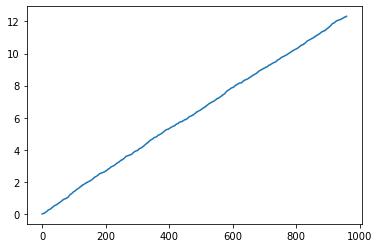

In [64]:
i = 1
plt.plot(healthytlm.loc[healthytlm.flight_id == 1, 'cumsum_i'])
plt.show()

## create normalizing layer

In [138]:
# normalizer = tf.keras.layers.Normalization(axis=-1)
# normalizer.adapt(np.array(train_df))

## simple regression using 1 variable

In [149]:
current = np.array(train_df['cumsum_i'])

current_normalizer = tf.keras.layers.Normalization(input_shape=[1,], axis=None)
current_normalizer.adapt(current)

In [150]:
current_model = tf.keras.Sequential([
    current_normalizer,
    layers.Dense(units=1)
])
current_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_7 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_4 (Dense)             (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [154]:
current_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.1), loss='mse') #'mean_absolute_error')

history = current_model.fit(
    train_df['cumsum_i'],
    train_y,
    epochs=3,
    validation_split=.2)


Epoch 1/3
14108/14108 [==============================] - 10s 688us/step - loss: 13271.8809 - val_loss: 13301.2891
Epoch 2/3
14108/14108 [==============================] - 10s 693us/step - loss: 13269.9111 - val_loss: 13304.5010
Epoch 3/3
14108/14108 [==============================] - 10s 699us/step - loss: 13270.3545 - val_loss: 13302.3232


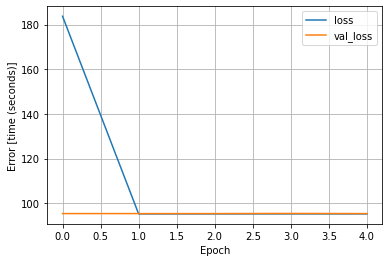

In [123]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [time (seconds)]')
    plt.legend()
    plt.grid(True)

plot_loss(history)

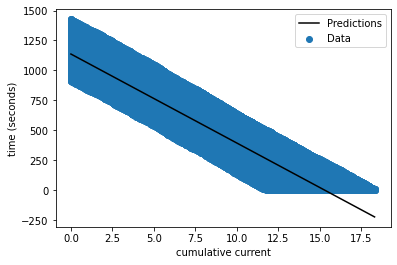

In [155]:
x = tf.linspace(0.0, max(test_df.cumsum_i), 100)
y = current_model.predict(x)
def plot_current(x, y):
    plt.scatter(train_df['cumsum_i'], train_y, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('cumulative current')
    plt.ylabel('time (seconds)')
    plt.legend()

plot_current(x, y)

In [156]:
current_model.evaluate(test_df['cumsum_i'], test_y)

4409/4409 [==============================] - 2s 499us/step - loss: 13355.0820


13355.08203125

In [145]:
current_model.evaluate(test_bad_df['cumsum_i'], test_bad_y)

1426/1426 [==============================] - 1s 519us/step - loss: 6.1527


6.152719497680664

## get flight data from heavily used uav and see results

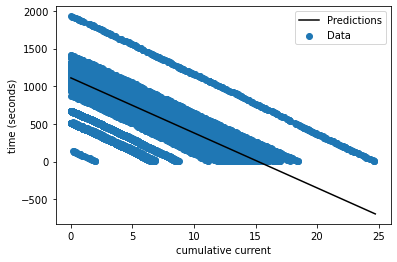

In [153]:
bad_df = sdf.loc[(sdf.flight_num > 80), :].sort_values(by=['uav_id', 'flight_num'])
bad_ids = bad_df.id.values.tolist()
bad_ids.sort()

badtlm = tmdf[tmdf['flight_id'].isin(bad_ids)].sort_values(by=['flight_id', 'dt']).drop(columns=['dt', 'x_pos_gps', 'y_pos_gps', 'z_pos_gps',
       'x_pos_true', 'y_pos_true', 'z_pos_true', 'x_vel_gps', 'y_vel_gps',
       'z_vel_gps', 'x_vel_true', 'y_vel_true', 'z_vel_true', 'battery_true_z', 'battery_true_r', 'm1_torque', 'm2_torque', 'm3_torque', 'm4_torque','m5_torque','m6_torque', 'm7_torque','m8_torque'])

for i in badtlm.flight_id.unique().tolist():
    #seconds =  np.arange(1, len(badtlm.loc[badtlm.flight_id == i])+1)
    seconds =  np.arange(len(badtlm.loc[badtlm.flight_id == i])+1, 1, -1)
    badtlm.loc[badtlm.flight_id == i, 'cumsum_i'] = badtlm.loc[badtlm.flight_id == i, 'battery_true_i'].cumsum()/3600
    badtlm.loc[badtlm.flight_id == i, 'time'] = seconds
    
train_bad_df = badtlm.sample(frac=.8, random_state=21)
test_bad_df = badtlm.drop(train_bad_df.index)

train_bad_y = train_bad_df.pop('time')
test_bad_y = test_bad_df.pop('time')

x = tf.linspace(0.0, max(train_bad_df.cumsum_i), 100)
y = current_model.predict(x)
def plot_current(x, y):
    plt.scatter(test_bad_df['cumsum_i'], test_bad_y, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('cumulative current')
    plt.ylabel('time (seconds)')
    plt.legend()

plot_current(x, y)

In [161]:
tmdf.loc[tmdf.remaining_time > 1900, 'flight_id'].unique()

array([1197, 1549, 1627], dtype=int64)

In [163]:
sdf.loc[sdf.id.isin([1197, 1549, 1627])]

,id,stop_code,z_start,z_end,v_start,v_end,m1_avg_current,m2_avg_current,m3_avg_current,m4_avg_current,...,flight_time,avg_current,amp_hours,dt_start,dt_stop,trajectory_id,uav_id,uav_version,flight_num,group_id
186,1549,4,0.999961,0.236376,22.199560,20.340466,5.628218,5.656172,5.642321,5.606971,...,21.568290,45.729721,16.438531,2023-02-14 18:00:14.057 -0600,2023-02-14 18:21:48.155 -0600,44,32,1,77,2
386,1627,2,1.000735,0.235226,22.200001,20.093063,5.627084,5.672801,5.675626,5.710231,...,21.591250,46.018447,16.559930,2023-02-16 16:07:02.881 -0600,2023-02-16 16:28:38.356 -0600,35,52,1,79,2
3523,1197,2,1.005819,0.594952,22.200001,20.296679,5.584293,5.566365,5.558244,5.608921,...,11.242917,45.364244,8.500440,2023-02-09 22:13:28.628 -0600,2023-02-09 22:24:43.203 -0600,51,432,1,86,2


## dnn with multiple inputs

In [ ]:
def build_and_compile_model(norm):
    model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model